In [73]:
import numpy as np
from transformers import Qwen3VLForConditionalGeneration, AutoProcessor, AutoModelForSeq2SeqLM, AutoTokenizer, T5Tokenizer
import torch
import os
import pandas as pd
from datasets import load_dataset
from typing import Dict, Any

import utils

SLURM_PATH = '/home/yandex/MLWG2025/amitr5'
CACHE_DIR = f'{SLURM_PATH}/tmp/hf_cache'  # Changed to /tmp to avoid quota issues

os.makedirs(CACHE_DIR, exist_ok=True)

if SLURM_PATH in os.getcwd():
    os.environ["PIP_PATH"] = f"{SLURM_PATH}/BaryGNN/anaconda3/envs/conf/bin/pip"
    os.environ["TEMP_DIR"] = CACHE_DIR
    os.environ["HF_HOME"] = CACHE_DIR
    os.environ["TRANSFORMERS_CACHE"] = CACHE_DIR
    os.environ["HF_DATASETS_CACHE"] = CACHE_DIR
    os.environ["HF_HUB_CACHE"] = CACHE_DIR
    os.environ["TMPDIR"] = CACHE_DIR
    # os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [ ]:
import importlib
import sys
sys.path.append('./Mind2Web/src') 

def reload(*module_names):
    for name in module_names:
        if name in sys.modules:
             importlib.reload(sys.modules[name])
             print(f"{name}- reloaded")
        else:
            print(f"{name}- NOT FOUND!")

In [ ]:
reload('action_prediction.dataloader')
from action_prediction.metric import ActionEvaluatorGeneration, ActionEvaluatorMultiChoice
from mind2web.dataloader import MultiChoiceDataset, get_data_split, subsample_by_annotation


def tensorize_item(item: Dict[str, Any], device: str):
    """
    Convert the model_input dict returned by MultiChoiceDataset.__getitem__
    (lists of ints) into tensors appropriate for model.generate.
    """
    input_ids = torch.LongTensor(item["input_ids"]).unsqueeze(0).to(device)
    attention_mask = torch.LongTensor(item["attention_mask"]).unsqueeze(0).to(device)
    return {"input_ids": input_ids, "attention_mask": attention_mask}


# Load tokenizer and model
# tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False, cache_dir=CACHE_DIR)
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-xl", cache_dir=CACHE_DIR)

device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "osunlp/MindAct_ActionPrediction_flan-t5-xl" #"Qwen/Qwen-3.5-VL-Base"
model = AutoModelForSeq2SeqLM.from_pretrained(model_name, cache_dir=CACHE_DIR)
model = model.to(device)
model.eval()



action_prediction.dataloader- reloaded


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

T5ForConditionalGeneration(
  (shared): Embedding(32128, 2048)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 2048)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=2048, out_features=2048, bias=False)
              (k): Linear(in_features=2048, out_features=2048, bias=False)
              (v): Linear(in_features=2048, out_features=2048, bias=False)
              (o): Linear(in_features=2048, out_features=2048, bias=False)
              (relative_attention_bias): Embedding(32, 32)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=2048, out_features=5120, bias=False)
              (wi_1): Linear(in_features=2048, out_features=5120, bias=False)
       

In [21]:
reload('mind2web.dataloader')
from mind2web.dataloader import MultiChoiceDataset, get_data_split, subsample_by_annotation

def build_split_datasets(
    split_files,
    tokenizer,
    seed=42,
    frac=0.1,
    num_candidates=5,
    max_context_len=512,
    data_dir="osunlp/Multimodal-Mind2Web",
    cache_dir=None,
    candidates_dir="candidates",
):
    """Return (cal_dict, test_dict) keyed by split name."""
    cal_dict, test_dict = {}, {}
    for split_file in split_files:
        cand_path = f"{candidates_dir}/scores_{split_file}.pkl"
        candidate_results = pd.read_pickle(cand_path)

        flattened = get_data_split(
            data_dir=data_dir,
            split_file=split_file,
            candidate_results=candidate_results,
            cache_dir=cache_dir,
        )

        cal_set, test_set = subsample_by_annotation(flattened, frac=frac, seed=seed)
        cal_dict[split_file] = MultiChoiceDataset(
            cal_set, tokenizer, num_candidates=num_candidates, max_context_len=max_context_len
        )
        test_dict[split_file] = MultiChoiceDataset(
            test_set, tokenizer, num_candidates=num_candidates, max_context_len=max_context_len
        )
    return cal_dict, test_dict


cal_dict, test_dict = build_split_datasets(["test_domain", "test_task", "test_website"],
                                            tokenizer,
                                              seed=42,
                                              frac=0.1,
                                              cache_dir=CACHE_DIR)


mind2web.dataloader- reloaded


Resolving data files:   0%|          | 0/27 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/27 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/27 [00:00<?, ?it/s]

In [ ]:
import random
import numpy as np
import torch.nn.functional as F
from tqdm import tqdm
# random.seed(42)
# np.random.seed(42)

choices_to_token_ids = cal_dict['test_domain'].choices_token_ids_mapping()
max_new_tokens = 1 #50


def run_evaluation(data_sets:list, max_iter=None):
    outputs = []
    for ds in data_sets:
        for i, item in enumerate(tqdm(ds, desc="Generating calibration set"), 1):
            if max_iter is not None and i > max_iter:
                break
            model_input = tensorize_item(item, device)

            with torch.no_grad():
                    out = model.generate(
                        **model_input,
                        eos_token_id=model.config.eos_token_id,
                        max_new_tokens=max_new_tokens,
                        return_dict_in_generate=True,
                        output_scores=True,
                    )

            decoded = tokenizer.batch_decode(out["sequences"], skip_special_tokens=True)[0]
            labels_tokens = item.get("labels")
            
            # Calculate choice probabilities
            logits = out["scores"][0][0]
            all_probs = F.softmax(logits, dim=-1)
            probs = all_probs[list(choices_to_token_ids.values())]
            choices_probs = dict(zip(choices_to_token_ids.keys(), probs.cpu().tolist()))
            labels = item.get("labels").strip()
            outputs.append(
                    [
                        i, 
                        item.get("annotation_id"),
                        item.get("action_uid"),
                        decoded,
                        labels.split('.')[0],
                        labels, 
                        choices_probs,
                        choices_probs.get(decoded, 0)
                    ]    
                )
        

    cols = ["index", "annotation_id", "action_uid", "generated", "label",'label_text', "choices_probs", "prob"]
    results_df = pd.DataFrame(outputs, columns=cols)
    return results_df


In [6]:
# cal_df = run_evaluation(list(cal_dict.values()))
# if len(cal_df):
#     cal_df.to_pickle("cal_results.pkl")
cal_df = pd.read_pickle("cal_results.pkl")
cal_df.head()

,index,annotation_id,action_uid,generated,label,label_text,choices_probs,prob
0,1,91695df8-f256-47c9-8c37-06e8d0fc758f,ea2865e4-2858-478c-bf83-93d576cad774,B,B,B.\nAction: TYPE\nValue: neurosurgeon,"{'A': 0.006505287252366543, 'B': 0.99326890707...",0.993269
1,2,91695df8-f256-47c9-8c37-06e8d0fc758f,c70a5d9b-8777-4ff7-a17d-1f76012e14ba,B,B,B.\nAction: CLICK,"{'A': 0.010167649947106838, 'B': 0.98960846662...",0.989608
2,3,91695df8-f256-47c9-8c37-06e8d0fc758f,3e671043-cab2-4e44-a1ce-3ed9de91d16b,B,B,B.\nAction: CLICK,"{'A': 0.009232945740222931, 'B': 0.99040365219...",0.990404
3,4,91695df8-f256-47c9-8c37-06e8d0fc758f,60888ab2-b605-4886-8dac-6ba72b6cde0a,A,A,A.,"{'A': 0.995083212852478, 'B': 0.00034710438922...",0.995083
4,5,91695df8-f256-47c9-8c37-06e8d0fc758f,43809daf-0eb6-40ab-96df-0c2bf143e25c,A,A,A.,"{'A': 0.9964125752449036, 'B': 0.0006053921533...",0.996413


In [66]:

def get_threshold(scores, alpha: float):
    N = len(scores)
    k = int(np.ceil((N + 1) * (1 - alpha)))
    sorted_scores = np.sort(scores.values)
    threshold = sorted_scores[k - 1]
    return threshold


cal_df['correct'] = cal_df['generated'] == cal_df['label']
# probability of the true label
cal_df['true_prob'] = cal_df.apply(lambda row: row['choices_probs'][row['label']] if row['label'] in row['choices_probs'] else 0, axis=1)
grouped = cal_df.groupby('annotation_id')
score_per_group = 1 - grouped['true_prob'].min()

threshold = get_threshold(score_per_group, alpha=0.1)
print(threshold)





0.9998509924771497


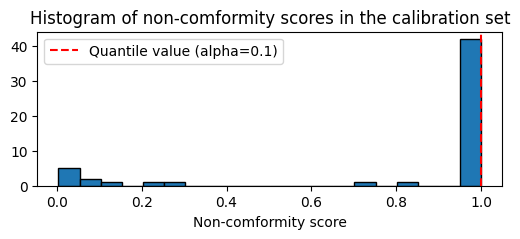

A good predictor should have low non-comformity scores, concentrated at the left side of the figure


In [65]:
import matplotlib.pyplot as plt

# plot histogram and quantile
plt.figure(figsize=(6, 2))
plt.hist(score_per_group, edgecolor='k', linewidth=1, bins=20)
plt.axvline(
    x=threshold, linestyle='--', color='r', label='Quantile value (alpha=0.1)'
)
# plt.axvline(
#     x=get_threshold(score_per_group, alpha=0.3), linestyle='--', color='b', label='Quantile value (alpha=0.2)'
# )
plt.title('Histogram of non-comformity scores in the calibration set')
plt.xlabel('Non-comformity score')
plt.legend()
plt.show()
print('A good predictor should have low non-comformity scores, concentrated at the left side of the figure')

Evaluation on Cal Set
Avg task accuracy: 0.7237
Avg annotation accuracy: 0.1852


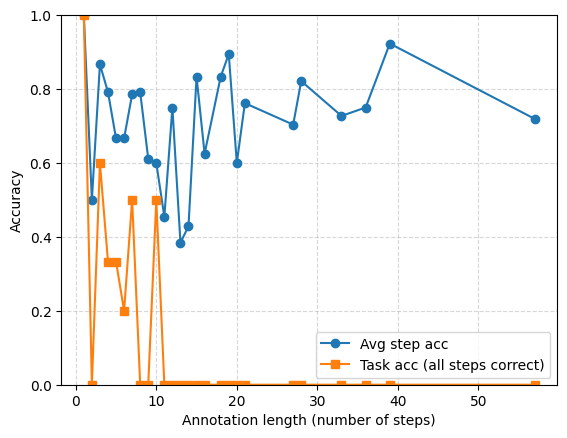

,length,step_acc_mean,task_acc_mean,n_annotations
0,1,1.000000,1.000000,1
1,2,0.500000,0.000000,2
2,3,0.866667,0.600000,5
3,4,0.791667,0.333333,6
4,5,0.666667,0.333333,3
5,6,0.666667,0.200000,5
6,7,0.785714,0.500000,2
7,8,0.791667,0.000000,3
8,9,0.611111,0.000000,6
9,10,0.600000,0.500000,2


In [98]:
print("Evaluation on Cal Set")
print(f"Avg task accuracy: {cal_df['correct'].mean():.4f}")
print(f"Avg annotation accuracy: {grouped['correct'].min().mean():.4f}")
utils.plot_accuracy_vs_length(cal_df)

In [90]:
# test_df = run_evaluation(test_dict.values(), max_iter=10)
# test_df.to_pickle("test_results.pkl")
test_df = pd.read_pickle("test_results.pkl")

test_df['correct'] = test_df['generated'] == test_df['label']
test_df['pred_set'] = test_df['choices_probs'].apply(lambda row: [ label for label, prob in row.items() if 1 - prob <= threshold])
test_df['pred_set_size'] = test_df['pred_set'].apply(len)
test_task_group = test_df.groupby('annotation_id')
test_df.head()

,index,annotation_id,action_uid,generated,label,label_text,choices_probs,prob,correct,pred_set,pred_set_size
0,1,277e3468-f8cb-45c6-9e4b-0328066c42d3,6584ac66-77f3-4b4f-878f-604d8c93ba48,A,B,B.\nAction: CLICK,"{'A': 0.9994745850563049, 'B': 2.4702232622075...",0.999475,False,[A],1
1,2,277e3468-f8cb-45c6-9e4b-0328066c42d3,d2f1a65e-ba3a-4aaf-9b6f-118069f32444,A,B,B.\nAction: CLICK,"{'A': 0.8732188940048218, 'B': 0.1246431320905...",0.873219,False,"[A, B, C, D, E, F]",6
2,3,277e3468-f8cb-45c6-9e4b-0328066c42d3,bd937d20-eae1-4028-958b-be2d2a0dd9b8,F,F,F.\nAction: TYPE\nValue: 60505,"{'A': 0.0017695568967610598, 'B': 1.1124548109...",0.998094,True,"[A, F]",2
3,4,277e3468-f8cb-45c6-9e4b-0328066c42d3,d078a194-660a-41bc-bacd-12abc3ad9fd5,A,F,F.\nAction: CLICK,"{'A': 0.9992172718048096, 'B': 9.2066329671069...",0.999217,False,"[A, F]",2
4,5,277e3468-f8cb-45c6-9e4b-0328066c42d3,29fccaeb-9af1-4e6a-acd3-bc89ff58eb3b,B,B,B.\nAction: CLICK,"{'A': 0.07011602073907852, 'B': 0.743930518627...",0.743931,True,"[A, B, C, D, E, F]",6


Evaluation on Test Set
Avg task accuracy: 0.6667
Avg annotation accuracy: 0.2500


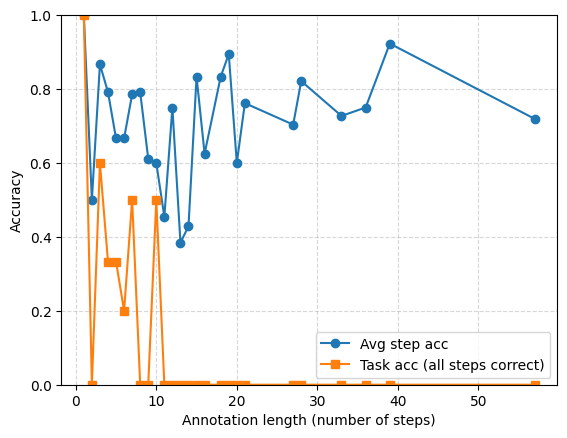

,length,step_acc_mean,task_acc_mean,n_annotations
0,1,1.000000,1.000000,1
1,2,0.500000,0.000000,2
2,3,0.866667,0.600000,5
3,4,0.791667,0.333333,6
4,5,0.666667,0.333333,3
5,6,0.666667,0.200000,5
6,7,0.785714,0.500000,2
7,8,0.791667,0.000000,3
8,9,0.611111,0.000000,6
9,10,0.600000,0.500000,2


In [99]:
print("Evaluation on Test Set")
print(f"Avg task accuracy: {test_df['correct'].mean():.4f}")
print(f"Avg annotation accuracy: {test_task_group['correct'].min().mean():.4f}")
utils.plot_accuracy_vs_length(cal_df)


In [100]:
len(grouped)


54

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

from mind2web.dataloader import MultiChoiceDataset, get_data_split
from mind2web.evaluate import FastActionEvaluatorMultiChoice  # note the file name
# if installed as a package, you can also do: from mind2web.evauate import FastActionEvaluatorMultiChoice

# Load tokenizer/model
# model_name = "osunlp/MindAct_ActionPrediction_flan-t5-xl"
# model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to("cuda")

# Prepare data (adjust paths/splits as needed)
# data_dir = "osunlp/Multimodal-Mind2Web"
# split_file = "test_task"  # example split
# data = get_data_split(data_dir, split_file)
# dataset = MultiChoiceDataset(data, tokenizer, num_candidates=5, max_context_len=512, mode="multichoice")

# Run evaluation
evaluator = FastActionEvaluatorMultiChoice(tokenizer, max_context_len=512)
result = evaluator.evaluate_dataset(
    test_dict["test_task"],  # dataset to evaluate
    model,
    batch_size=8,
    top_k=50,
    output_path='./results',  # set a folder path to save JSON outputs
    name="test_task",
    template=None,     # optionally a tuple (prefix_context, suffix_input)
    max_new_tokens=50,
)

print(result)


/home/yandex/MLWG2025/amitr5/BaryGNN/anaconda3/envs/conf/lib/python3.13/site-packages/PIL/Image.py:3432: DecompressionBombWarning: Image size (125915272 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
import sys
import importlib

sys.path.append('./Mind2Web/src') 

# Force reload the metric module
if 'action_prediction.metric' in sys.modules:
    importlib.reload(sys.modules['action_prediction.metric'])

from action_prediction.metric import ActionEvaluatorGeneration, ActionEvaluatorMultiChoice

evaluator = ActionEvaluatorMultiChoice(tokenizer)
test_dataset = dataset
test_key = "task"
output_path = os.getcwd()
result = evaluator.evaluate_dataset(
    test_dataset,
    model,
    output_path=output_path,
    name=test_key,
    template=None, #lm_template,
    top_k=50#cfg.top_k,)
)


 12%|█▏        | 158/1339 [48:58<6:06:01, 18.60s/it, action_f1=0, element_acc=0]



KeyboardInterrupt: 

In [ ]:
# df = pd.DataFrame(test_task_ds)
# len(df.groupby("annotation_id"))
# subsample[0]['action_reprs']

# test_domain_ds = ds['test_domain']
# test_task_ds = ds['test_task']
# test_website_ds = ds['test_website']
count = 0
missing_count = 0
mulit = {}
missing = {}
for i, x in enumerate(test_task_ds):
    if len(x['pos_candidates']) > 1:
        count += 1
        mulit[i] = x['annotation_id']
    if len(x['pos_candidates']) == 0:
        # print('Missing pos_candidates:', x['annotation_id'])
        missing_count += 1
        missing[i] = x['annotation_id']

print("Number of samples with multiple positive candidates in test_website:", count)
print("Number of samples with missing positive candidates in test_website:", missing_count)

In [ ]:

import argparse
import json
import pathlib
import sys
from typing import Any, Dict

import torch
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

# Import the repository's dataset utilities
from action_prediction.dataloader import MultiChoiceDataset, get_data_split  # type: ignore





def main():
    parser = argparse.ArgumentParser()
    parser.add_argument("--model-name", default="google/flan-t5-base")
    parser.add_argument("--data-dir", required=True, help="data dir or dataset script used by get_data_split")
    parser.add_argument("--split-file", required=True, help="path to split json file or list accepted by get_data_split")
    parser.add_argument("--num-samples", type=int, default=10)
    parser.add_argument("--device", default="cuda" if torch.cuda.is_available() else "cpu")
    parser.add_argument("--out", default="multichoice_generations.json")
    parser.add_argument("--max-new-tokens", type=int, default=50)
    args = parser.parse_args()

    outputs = generate_with_dataset(
        model_name=args.model_name,
        data_dir=args.data_dir,
        split_file=args.split_file,
        num_samples=args.num_samples,
        device=args.device,
        max_new_tokens=args.max_new_tokens,
    )

    with open(args.out, "w") as f:
        json.dump(outputs, f, indent=2)
    print(f"Wrote {len(outputs)} generations to {args.out}")


if __name__ == "__main__":
    main()

In [4]:
# Group by annotation_id (this creates a GroupBy object for fast access)
grouped = df.groupby('annotation_id')

# Retrieve all rows for a specific annotation_id
ann_id = train_ds[0]["annotation_id"]
task_df = grouped.get_group(ann_id).sort_values('target_action_index')

print(f"Task: {task_df.iloc[0]['confirmed_task']}")
# Iterate and display (task_df is a DataFrame)
for _, ex in task_df.iterrows():
    print(
        f"step={int(ex['target_action_index']) + 1}/{len(task_df)} | op={ex['operation']} "
        f"| target_action={ex["target_action_reprs"]} | pos_candidates={len(ex['pos_candidates'])}, action_id={ex['action_id']}"
    )
    # display(train_ds[ex["action_id"]]["screenshot"])

Task: rent a car in Brooklyn - Central, NY on from April 9 to April 15.
step=1/7 | op={"original_op": "CLICK", "value": "", "op": "CLICK"} | target_action=[heading]  CAR -> CLICK | pos_candidates=1, action_id=0
step=2/7 | op={"original_op": "TYPE", "value": "Brooklyn Central", "op": "TYPE"} | target_action=[combobox]  Enter pick up city, airport name, or airport code. -> TYPE: Brooklyn Central | pos_candidates=1, action_id=1
step=3/7 | op={"original_op": "CLICK", "value": "", "op": "CLICK"} | target_action=[div]  Brooklyn - Central (New York), US -> CLICK | pos_candidates=1, action_id=2
step=4/7 | op={"original_op": "CLICK", "value": "", "op": "CLICK"} | target_action=[textbox]  Pickup -> CLICK | pos_candidates=1, action_id=3
step=5/7 | op={"original_op": "CLICK", "value": "", "op": "CLICK"} | target_action=[button]  Sunday, April 9, 2023 -> CLICK | pos_candidates=1, action_id=4
step=6/7 | op={"original_op": "CLICK", "value": "", "op": "CLICK"} | target_action=[button]  Saturday, April

In [12]:
import torch
import sys
import os

# Add Mind2Web to path so we can import from it
sys.path.append('./Mind2Web/src')

from candidate_generation.dataloader import CandidateRankDataset, get_data_split
from candidate_generation.metric import CERerankingEvaluator
from candidate_generation.model import CrossEncoder
from torch.utils.data import DataLoader

eval_data = train_ds
batch_size = 350
max_seq_length = 512

eval_evaluator = CERerankingEvaluator(
    eval_data,
    k=50,
    max_neg=-1,
    batch_size=batch_size,
    name="train",
)

# Use the model path for the CrossEncoder (like in evaluate.py)
model_path = "osunlp/MindAct_CandidateGeneration_deberta-v3-base"
model = CrossEncoder(
    model_path,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    num_labels=1,
    max_length=max_seq_length,
)

# Evaluate the model
print("Running evaluation...")
eval_evaluator(model, output_path="./output")
print("Evaluation completed!")
print("Results saved to: ./output")

ModuleNotFoundError: No module named 'dataloader'

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Download the MindAct Candidate Generation model
print("Downloading MindAct Candidate Generation model...")
model_name = "osunlp/MindAct_CandidateGeneration_deberta-v3-base"

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir=CACHE_DIR)

# Load model
candidate_model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    cache_dir=CACHE_DIR,
    torch_dtype=torch.float16,  # Use float16 for efficiency
    device_map="auto"  # Automatically handle device placement
)

print(f"Model {model_name} downloaded and loaded successfully!")
print(f"Model type: {type(candidate_model)}")
print(f"Number of parameters: {sum(p.numel() for p in candidate_model.parameters()):,}")